# 0.0 Imports

In [1]:
import numpy as np
import pandas as pd
import inflection
import math
import seaborn as sns
from IPython.core.display import HTML
from IPython.display import Image
import datetime
from scipy import stats  as ss

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

## 0.1 Helper Functions

In [2]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        xtraining = training.drop(['date','sales'],axis=1)
        ytraining = training['sales']
        xvalidation = validation.drop(['date','sales'],axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining,ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error('Linear Regression', np.expm1(yvalidation),np.expm1(yhat))

        # store performance of each iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame(
        {'Model Name': model_name,
         'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
         'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)},index=[0])

def mean_absolute_percentage_error(y,yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE':mape,
                         'RMSE':rmse},index=[0])

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw,df_store_raw, how='left',on='Store')

In [4]:
df_sales_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
df_store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 Data Description

In [7]:
df1 = df_raw.copy()

In [8]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

**Id** - an Id that represents a (Store, Date) duple within the test set

**Store** - a unique Id for each store

**Sales** - the turnover for any given day (this is what you are predicting)

**Customers** - the number of customers on a given day

**Open** - an indicator for whether the store was open: 0 = closed, 1 = open

**StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

**SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools

**StoreType** - differentiates between 4 different store models: a, b, c, d

**Assortment** - describes an assortment level: a = basic, b = extra, c = extended

**CompetitionDistance** - distance in meters to the nearest competitor store

**CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened

**Promo** - indicates whether a store is running a promo on that day

**Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

**Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2

**PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## 1.1 Rename Columns

In [9]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 
            'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2 - Data Dimensions

In [10]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 - Data Types

In [11]:
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [13]:
df1.sample(1)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
257612,795,2,2014-12-09,3537,412,1,0,0,0,d,a,510.0,NaN,NaN,1,35.0,2010.0,"Mar,Jun,Sept,Dec"


In [14]:
# competition_distance              
# Se vazio, não há competidor mais próximo (a distancia até o competidor é mto grande)
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 2*10**5 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1[['competition_open_since_month','date']].apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year   
df1['competition_open_since_year'] = df1[['competition_open_since_year','date']].apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1[['promo2_since_week','date']].apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1[['promo2_since_year','date']].apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sept',10:'Out',11:'Nov',12:'Dec'}

df1['promo_interval'].fillna(0,inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [15]:
df1.sample(5).T

,230556,237731,816280,774815,784192
store,867,495,886,676,18
day_of_week,2,2,7,2,7
date,2015-01-06 00:00:00,2014-12-30 00:00:00,2013-06-30 00:00:00,2013-08-06 00:00:00,2013-07-28 00:00:00
sales,5008,4506,0,5448,0
customers,426,373,0,1436,0
open,1,1,0,1,0
promo,1,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,1,1,0,1,0
store_type,d,d,a,b,d


## 1.6 Change Types

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int64)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int64)

## 1.7 Descriptive Statistical

In [18]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [19]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max','range','mean','median','std','skew','kurtosis']

In [20]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\Notebook\anaconda3\envs\ds-producao-env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

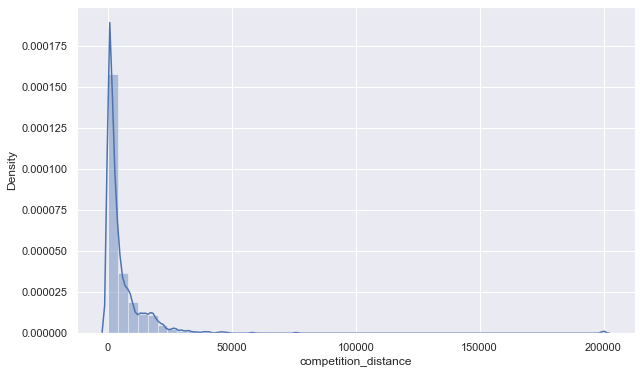

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
sns.distplot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [22]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

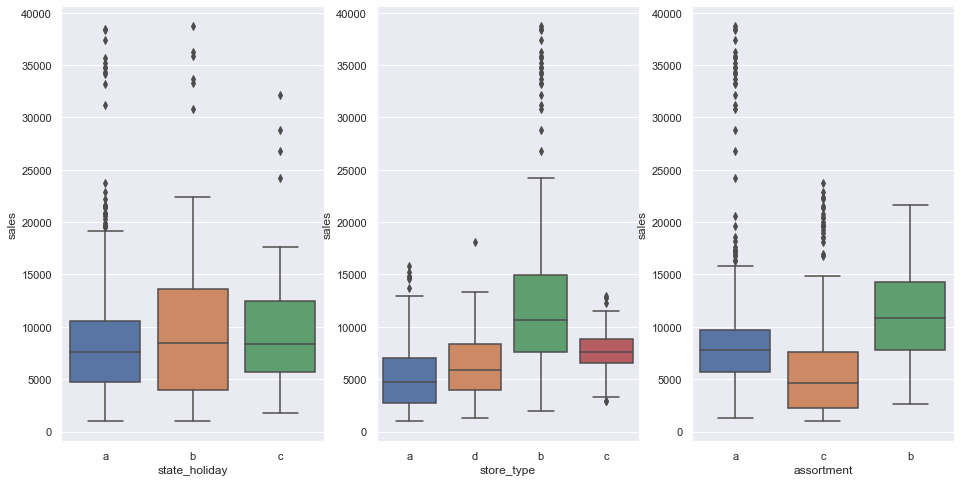

In [23]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(16,8))

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday' , y='sales' , data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type' , y='sales' , data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment' , y='sales' , data=aux1)

# 2.0 - Feature Engeneering

In [24]:
df2 = df1.copy()

## 2.1 - Mapa Mental de Hipóteses

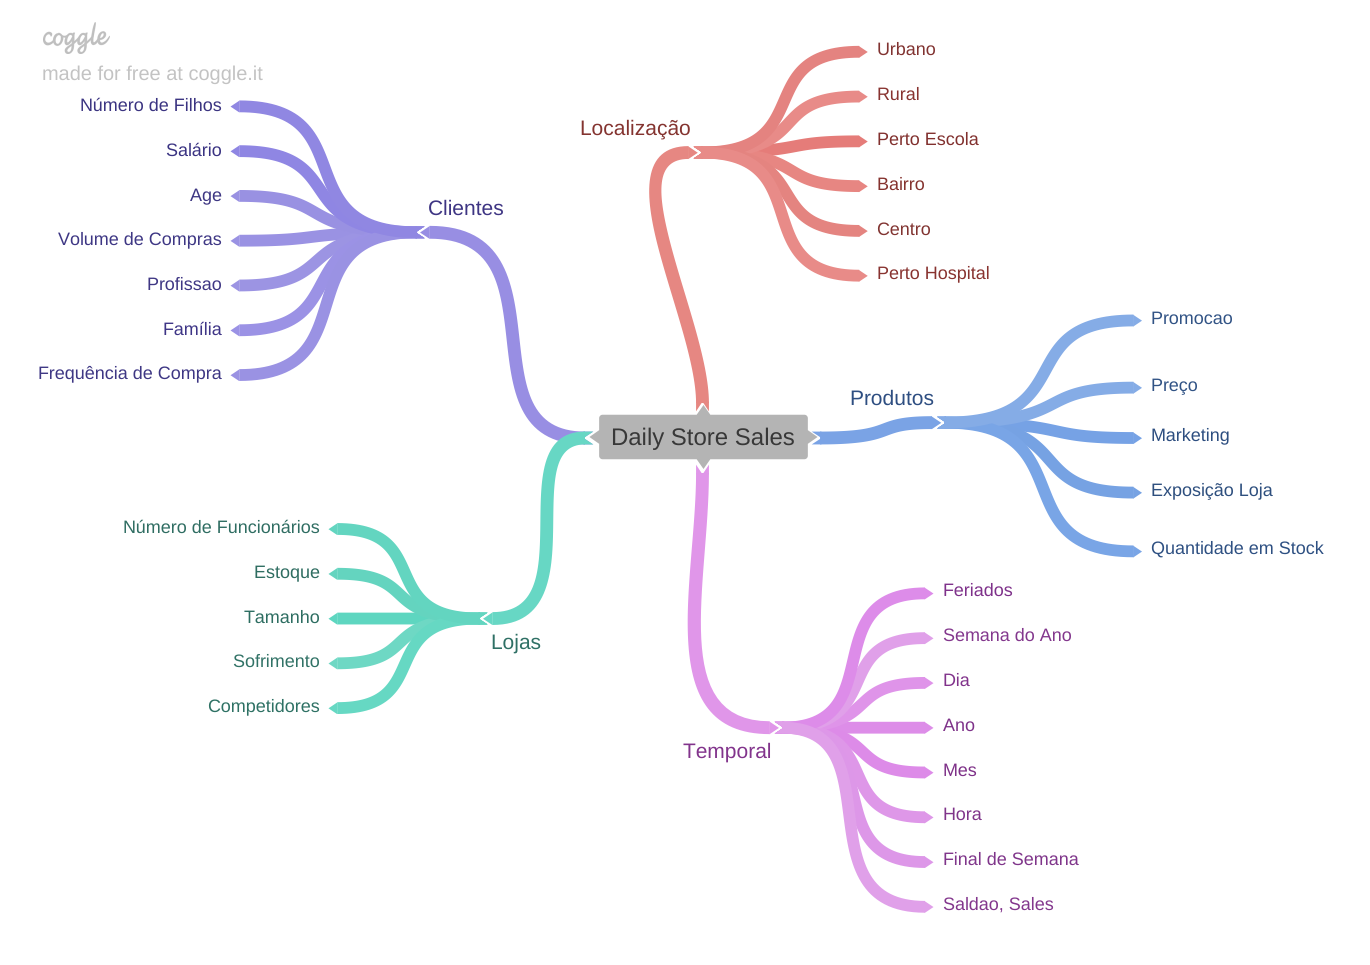

In [25]:
Image('img/Daily_Store_Sales.png')

## 2.2 - Mapa Mental de Hipóteses

### 2.2.1. Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipóteses Loja

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Lista Final de Hipoteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [26]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of day
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition_sice
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int64)

# promo sice
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) + '-1'
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x=='b' else 'christmas' if x =='c' else 'regular_day') 

In [27]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [28]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

# 3.0 PASSO 3 - FILTRAGEM DE VARIÁVEIS

In [29]:
df3 = df2.copy()

In [30]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das Linhas

In [31]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Selecao das Colunas

In [32]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

In [33]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 PASSO 04 - ANÁLISE EXPLORATÓRIA DE DADOS

In [34]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response Variable

C:\Users\Notebook\anaconda3\envs\ds-producao-env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

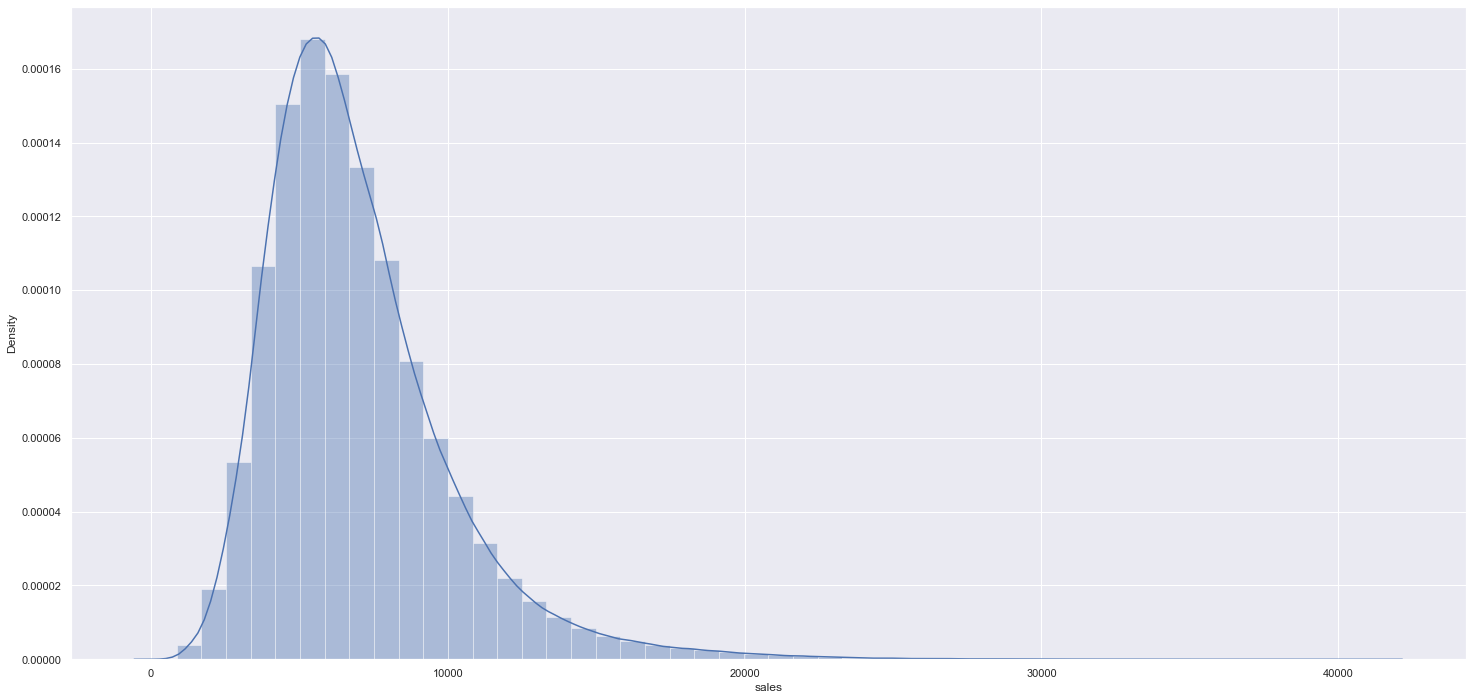

In [35]:
sns.distplot(df4['sales'])

### 4.1.2. Numerical Variable

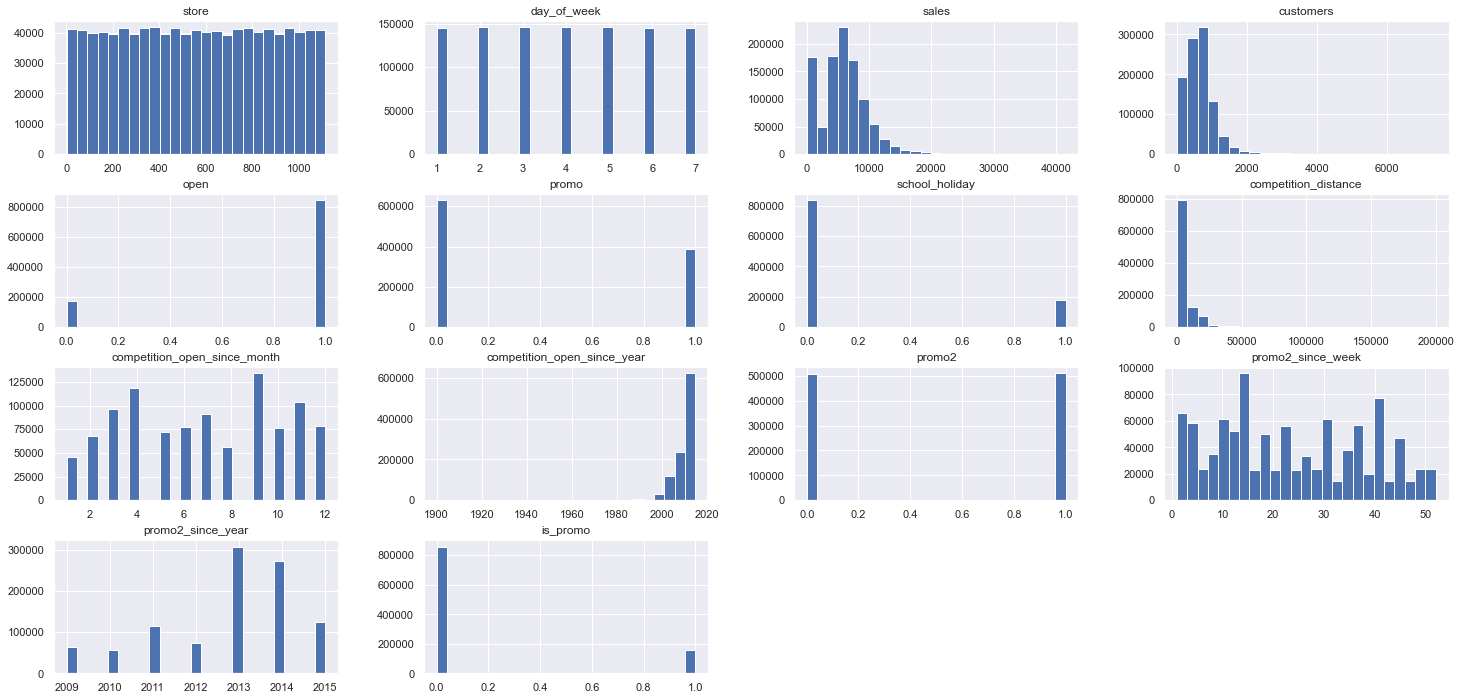

In [36]:
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variable

In [37]:
df4['state_holiday'].value_counts(normalize=True)

regular_day       0.998922
public_holiday    0.000822
easter_holiday    0.000172
christmas         0.000084
Name: state_holiday, dtype: float64

C:\Users\Notebook\anaconda3\envs\ds-producao-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Notebook\anaconda3\envs\ds-producao-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Notebook\anaconda3\envs\ds-producao-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an erro

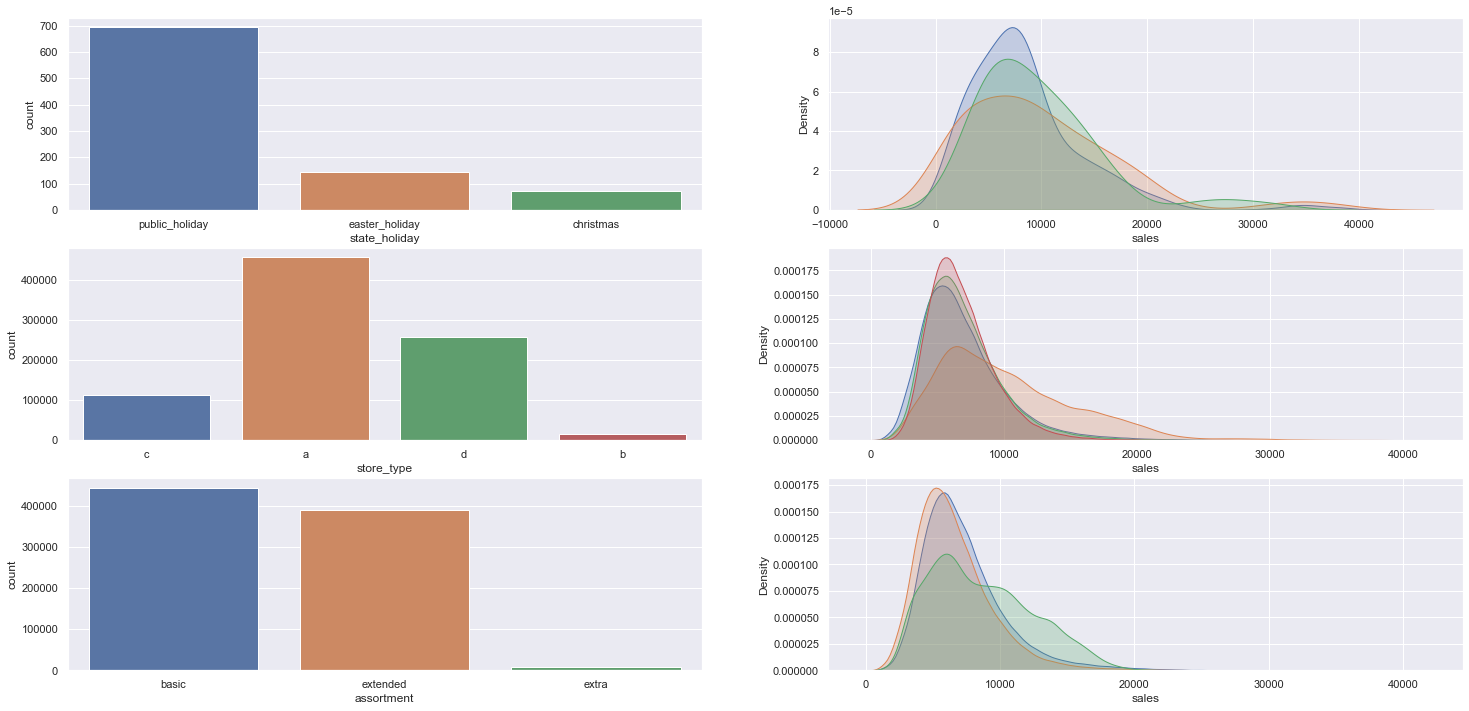

In [38]:
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],label='public_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],label='easter_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],label='christmas',shade=True)

plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'],label='a',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'],label='b',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'],label='c',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'],label='d',shade=True)

plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended',shade='True')
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic',shade='True')
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra',shade='True');

## 4.2. Análise Bivariada

### **H1.** Lojas com maior variedade de produtos deveriam vender mais.

<AxesSubplot:xlabel='date', ylabel='sales'>

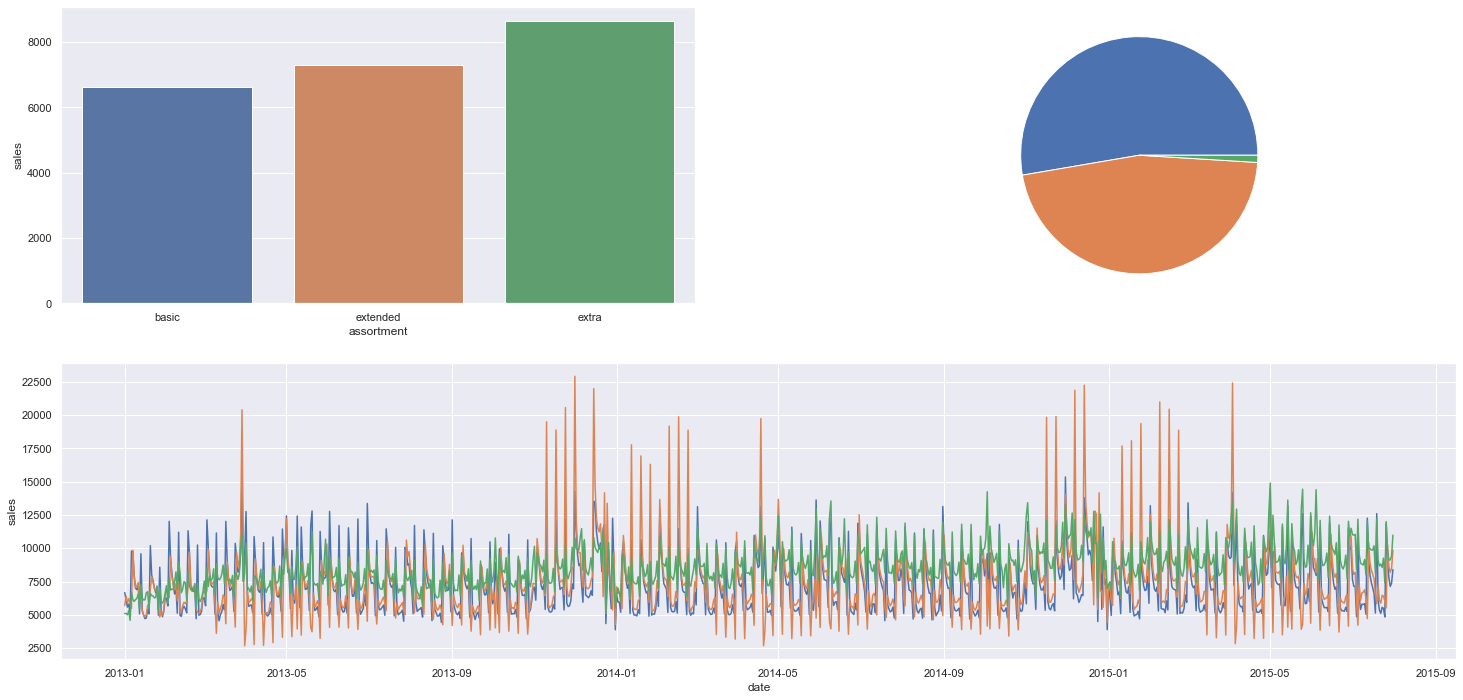

In [39]:
grid = GridSpec(2,2)

plt.subplot(grid[0,0])
aux1 = df4[['assortment','sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment',y='sales',data=aux1);

plt.subplot(grid[0,1])

aux1 = pd.DataFrame(df4['assortment'].value_counts()).reset_index()
plt.pie(data=aux1,x='assortment');

plt.subplot(grid[1,:])

aux2 = df4[['date','assortment','sales']].groupby(['date','assortment']).mean().reset_index()
# aux2 = aux2[aux2['date'] < '2014-01-01']
sns.lineplot(data=aux2[aux2['assortment'] == 'basic'], x='date',y='sales')
sns.lineplot(data=aux2[aux2['assortment'] == 'extended'], x='date',y='sales')
sns.lineplot(data=aux2[aux2['assortment'] == 'extra'], x='date',y='sales')

### **H2.** Lojas com competidores mais próximos deveriam vender menos.

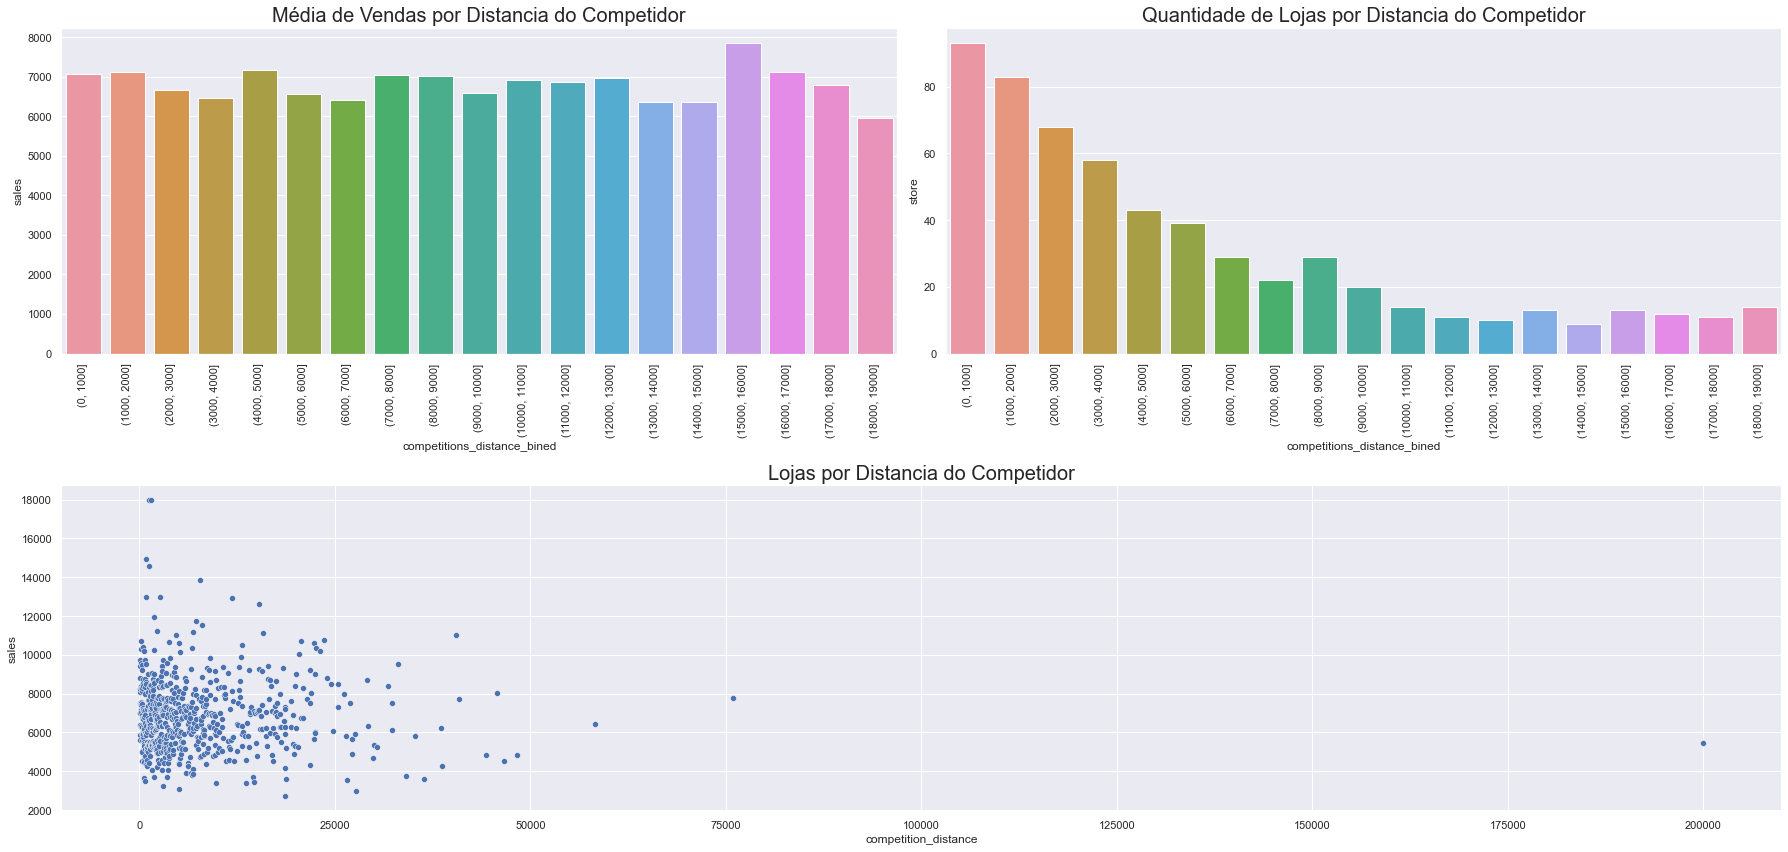

In [40]:
grid = GridSpec(2,2)

plt.subplot(grid[0,0])
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').mean().reset_index()
bins = list(np.arange(0,20000,1000))
aux1['competitions_distance_bined'] = pd.cut(aux1['competition_distance'],bins=bins)
aux2 = aux1[['competitions_distance_bined','sales']].groupby('competitions_distance_bined').mean().reset_index()
sns.barplot(x='competitions_distance_bined',y='sales',data=aux2)
plt.title('Média de Vendas por Distancia do Competidor',size=20)
plt.xticks(rotation=90)

plt.subplot(grid[0,1])
aux3 = df4[['competition_distance','store']].groupby('competition_distance').count().reset_index()
aux3['competitions_distance_bined'] = pd.cut(aux3['competition_distance'],bins=bins)
aux4 = aux3[['competitions_distance_bined','store']].groupby('competitions_distance_bined').count().reset_index()
sns.barplot(data=aux4, x='competitions_distance_bined',y='store')
plt.title('Quantidade de Lojas por Distancia do Competidor',size=20)
plt.xticks(rotation=90)

plt.subplot(grid[1,:])
sns.scatterplot(x='competition_distance', y='sales',data=aux1);
plt.title('Lojas por Distancia do Competidor',size=20)

# plt.subplot(grid[0,1])
# sns.heatmap(aux1.corr(method='pearson'),annot=True);
plt.tight_layout()

### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.

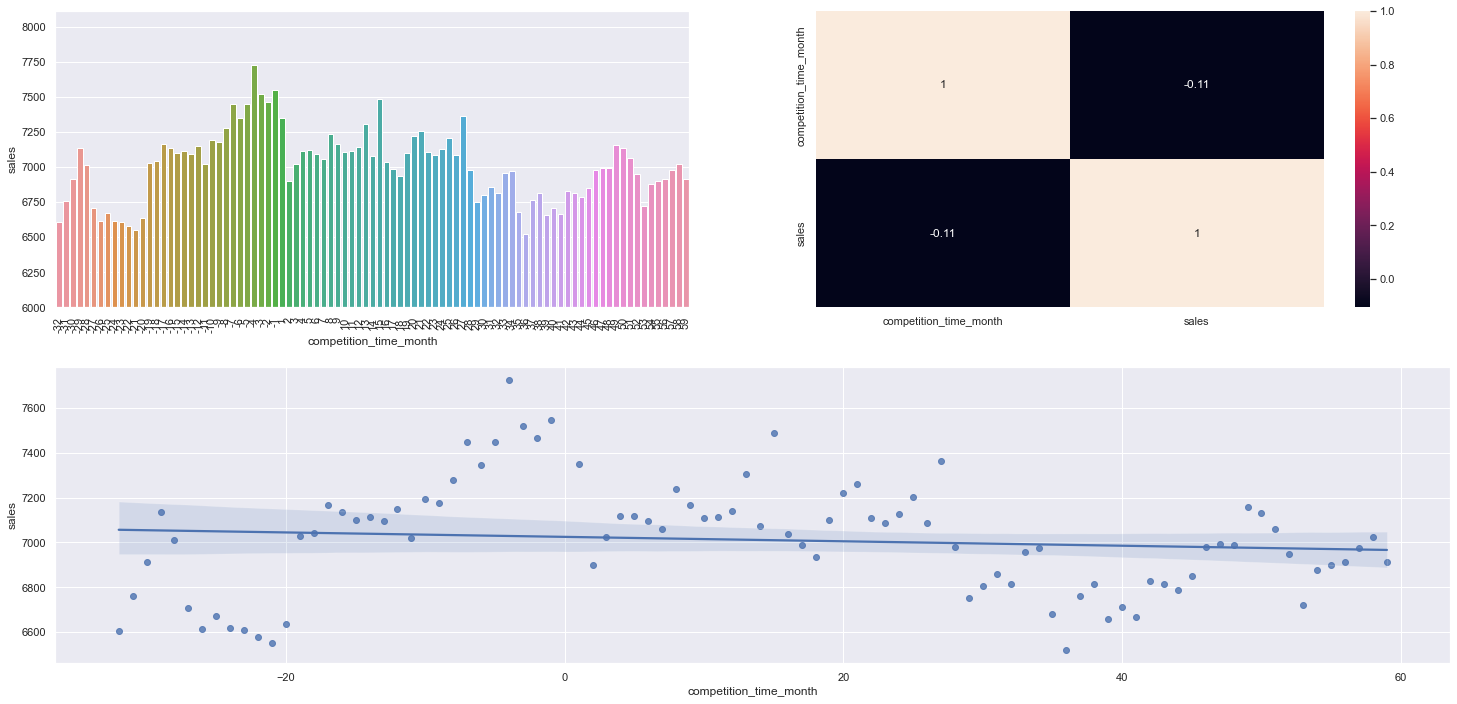

In [41]:
grid = GridSpec(2,2)

plt.subplot(grid[0,0])
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').mean().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 60) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month',y='sales',data=aux2);
plt.xticks(rotation=90)
plt.ylim(bottom=6000)

plt.subplot(grid[1,:])
sns.regplot(x='competition_time_month', y='sales',data=aux2);

plt.subplot(grid[0,1])
# aux1 = df4[['competition_time_month','store']].groupby('competition_time_month').count().reset_index()
# aux2 = aux1[(aux1['competition_time_month'] < 60) & (aux1['competition_time_month'] != 0)]
# sns.barplot(x='competition_time_month',y='store',data=aux2);
# plt.xticks(rotation=90);
sns.heatmap(aux2.corr(method='pearson'),annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

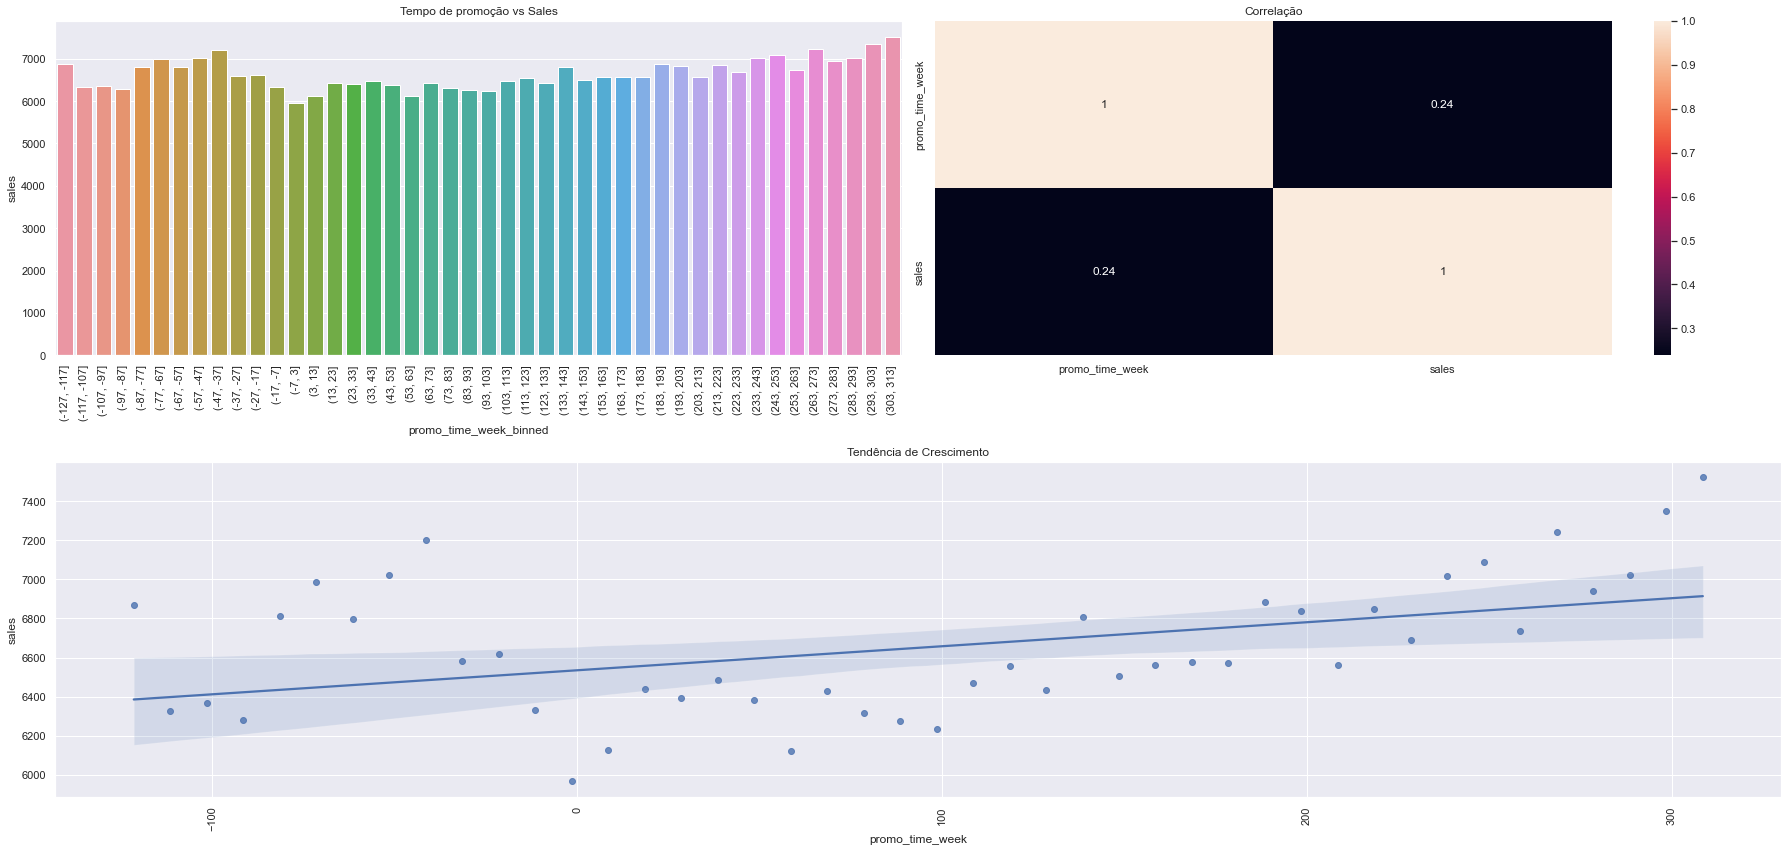

In [42]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').mean().reset_index()

bins = list(np.arange(aux1['promo_time_week'].min()-1,aux1['promo_time_week'].max()+1,10))
aux1['promo_time_week_binned'] = pd.cut(aux1['promo_time_week'],bins=bins)

aux2 = aux1.groupby('promo_time_week_binned').mean().reset_index()

grid = GridSpec(2,2)

plt.subplot(grid[0,0])
sns.barplot(x='promo_time_week_binned', y='sales', data=aux2);
plt.title('Tempo de promoção vs Sales')
plt.xticks(rotation=90);
plt.tight_layout()

plt.subplot(grid[1,:])
sns.regplot(x='promo_time_week', y='sales',data=aux2);
plt.xticks(rotation=90);
plt.title('Tendência de Crescimento')
plt.tight_layout()

plt.subplot(grid[0,1])
sns.heatmap(aux1.corr(method='pearson'),annot=True);
plt.title('Correlação')
plt.tight_layout()

### **H5.** Lojas com mais dias de promoção deveriam vender mais.

### **H7.** Lojas com mais promoções consecutivas deveriam vender mais.

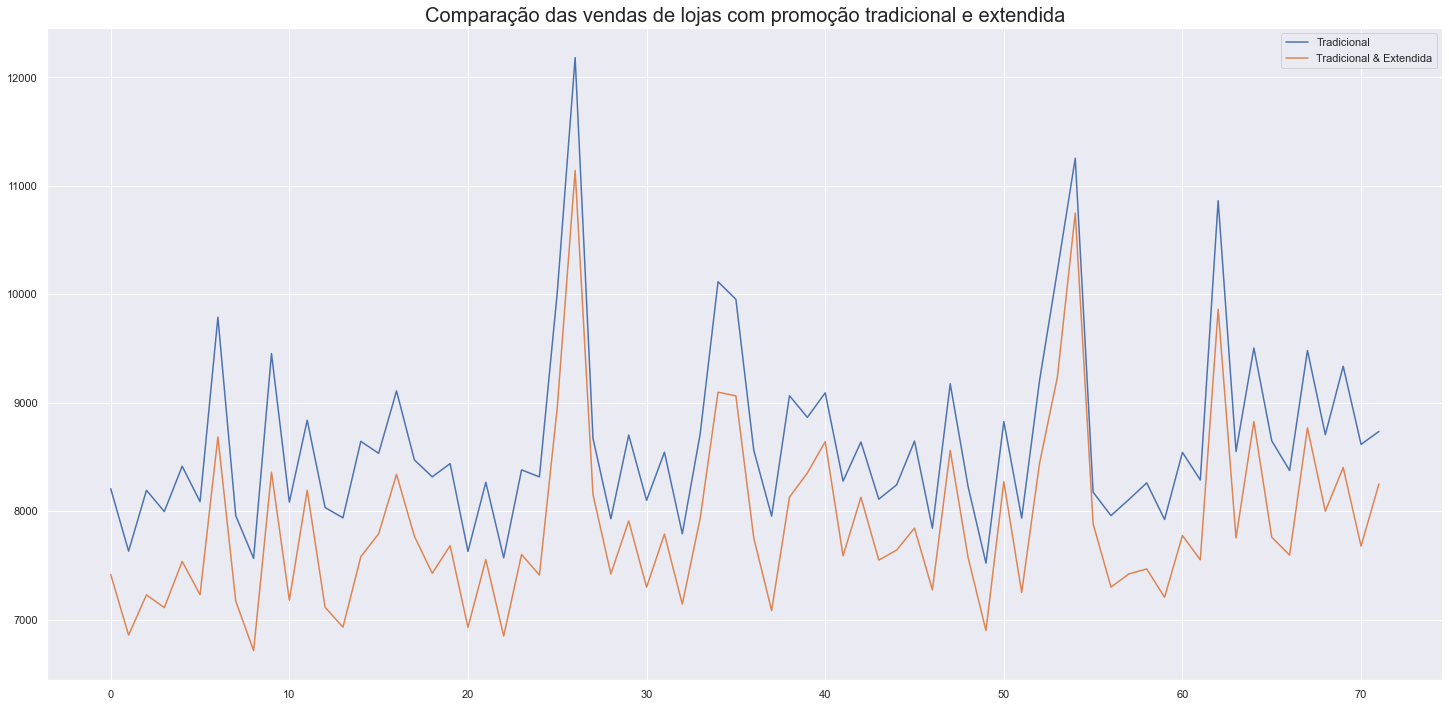

In [43]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').mean().reset_index()
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').mean().reset_index()

ax = aux1.plot()
aux2.plot(ax=ax)

plt.title('Comparação das vendas de lojas com promoção tradicional e extendida',fontsize=20)
ax.legend(labels=['Tradicional','Tradicional & Extendida'])

### H8. Lojas abertas durante o feriado de Natal deveriam vender mais.

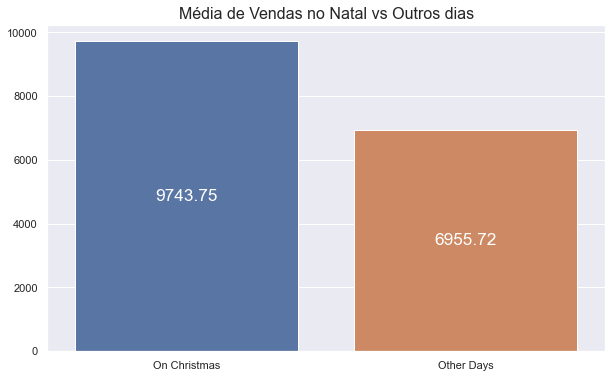

In [44]:
sales_on_christmas = df4[df4['state_holiday'] == 'christmas']['sales'].mean()
sales_others_days = df4[df4['state_holiday'] != 'christmas']['sales'].mean()

fig = plt.figure(figsize=(10,6))
g = sns.barplot(x=['On Christmas','Other Days'],y=[sales_on_christmas,sales_others_days])
plt.title('Média de Vendas no Natal vs Outros dias',fontsize=16)

for i in g.containers:
    g.bar_label(i,color='white', label_type= 'center',fontsize='x-large',fmt='%.2f')

### H9. Lojas deveriam vender mais ao longo dos anos.

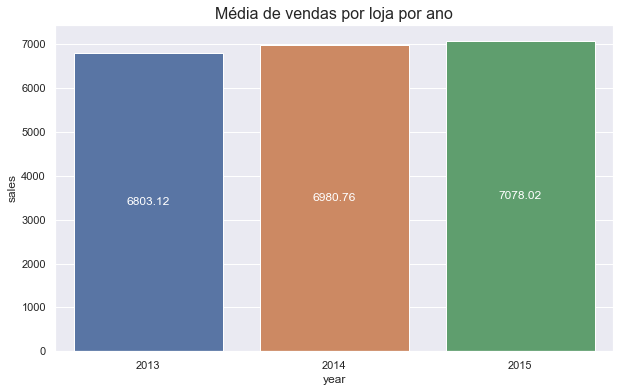

In [45]:
aux1 = df4[['year','store','sales']].groupby(['year','store']).mean().reset_index()
sales_per_year = aux1[['year','sales']].groupby('year').mean().reset_index()

fig = plt.figure(figsize=(10,6))
plt.title('Média de vendas por loja por ano',fontsize=16)
g = sns.barplot(x='year',y='sales',data=sales_per_year)

for i in g.containers:
    g.bar_label(i,color='white',label_type='center')

### H10. Lojas deveriam vender mais no segundo semestre do ano.

VERDADEIRO. No 2º semestre as vendas são 2.71% maior que no 1º semestre


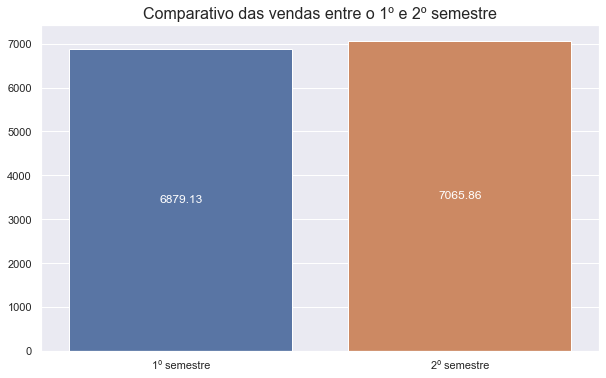

In [46]:
S1 = df4[df4['month'] <= 6]['sales'].mean() 
S2 = df4[df4['month'] > 6]['sales'].mean()

diff = (S2 - S1)

fig = plt.figure(figsize=(10,6))
plt.title('Comparativo das vendas entre o 1º e 2º semestre',fontsize=16)
g = sns.barplot(x=['1º semestre','2º semestre'],y=[S1,S2])

for i in g.containers:
    g.bar_label(i, color='white',label_type='center')
    
print(f'VERDADEIRO. No 2º semestre as vendas são {round(diff*100/(S1),2)}% maior que no 1º semestre')

### H11. Lojas deveriam vender mais depois do dia 10 de cada mês.

Após o dia 10, as vendas são em média 8% menores


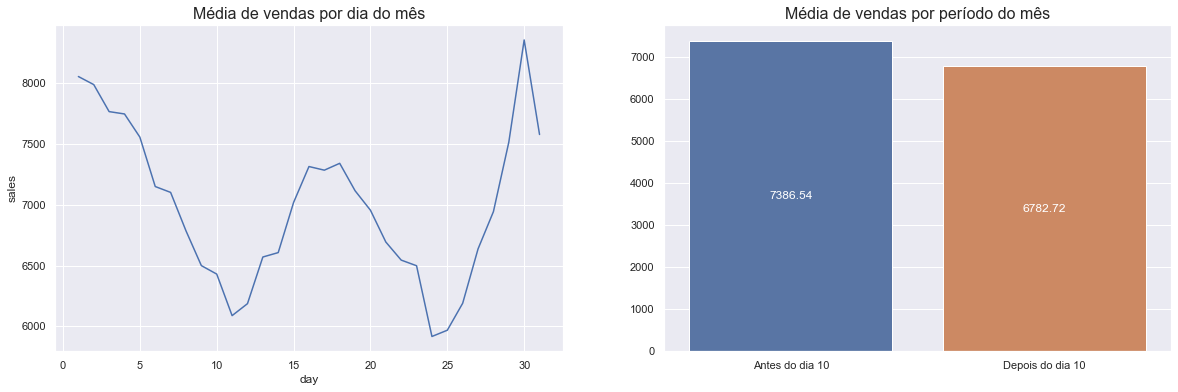

In [47]:
grid = GridSpec(1,2)

fig = plt.figure(figsize=(20,6))
plt.subplot(grid[0,0])

aux1 = df4[['day','sales']].groupby('day').mean().reset_index()
sns.lineplot(x='day',y='sales',data=aux1)
plt.title('Média de vendas por dia do mês',fontsize=16)

plt.subplot(grid[0,1])

sales_before_10d = df4[df4['day'] < 10]['sales'].mean()
sales_after_10d = df4[df4['day'] >= 10]['sales'].mean()
diff = sales_before_10d - sales_after_10d

print(f'Após o dia 10, as vendas são em média {round(diff*100/sales_before_10d)}% menores')

plt.title('Média de vendas por período do mês',fontsize=16)
g = sns.barplot(x=['Antes do dia 10', 'Depois do dia 10'],y=[sales_before_10d,sales_after_10d])
for i in g.containers:
    g.bar_label(i, color='white',label_type='center')

### H12. Lojas deveriam vender menos aos finais de semana.

As vendas nos fim de semana são até 22.58% maiores que nos dias úteis


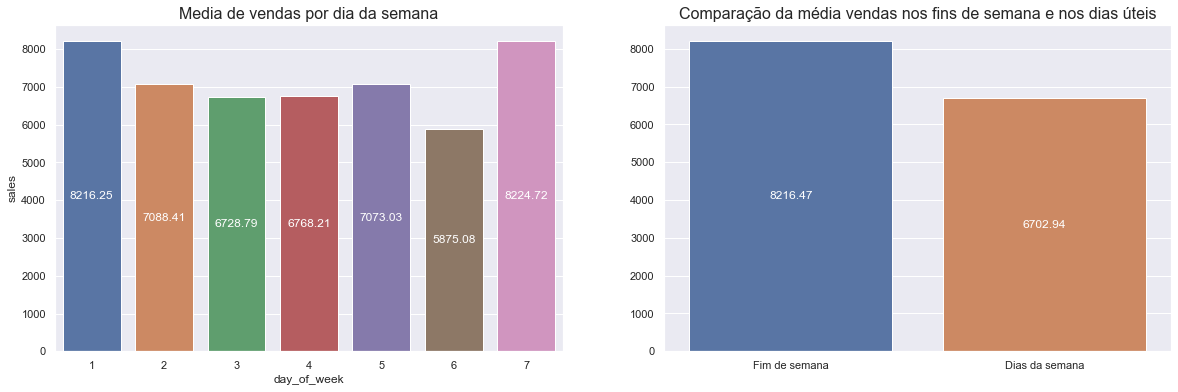

In [48]:
grid = GridSpec(1,2)
fig = plt.figure(figsize=(20,6))

plt.subplot(grid[0,0])
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').mean().reset_index()
g = sns.barplot(x='day_of_week',y='sales',data=aux1)
plt.title('Media de vendas por dia da semana', fontsize=16)
for i in g.containers:
    g.bar_label(i,color='white',label_type='center')

plt.subplot(grid[0,1])

sales_on_weekend = df4[(df4['day_of_week'] == 1) | (df4['day_of_week'] == 7)]['sales'].mean()
sales_on_weekday = df4[(df4['day_of_week'] != 1) & (df4['day_of_week'] != 7)]['sales'].mean()
diff = sales_on_weekend - sales_on_weekday

g = sns.barplot(x=['Fim de semana','Dias da semana'],y=[sales_on_weekend,sales_on_weekday])
plt.title('Comparação da média vendas nos fins de semana e nos dias úteis',fontsize=16)
for i in g.containers:
    g.bar_label(i,color='white',label_type='center')
    
print(f'As vendas nos fim de semana são até {round(diff*100/sales_on_weekday,2)}% maiores que nos dias úteis')

### H13. Lojas deveriam vender menos durante os feriados escolares.

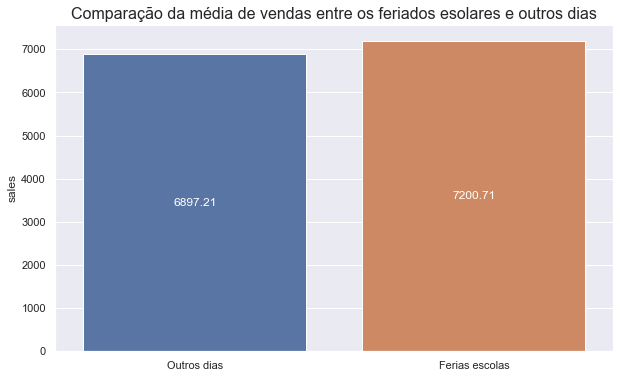

In [49]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').mean().reset_index()

fig = plt.figure(figsize=(10,6))
plt.title('Comparação da média de vendas entre os feriados esolares e outros dias',fontsize=16)
g = sns.barplot(x=['Outros dias','Ferias escolas'],y='sales',data=aux1)
for i in g.containers:
    g.bar_label(i,color='white',label_type='center')

In [50]:
! pip install tabulate

## 4.3. Análise Multivariada

### 4.3.1 Numerical Attributes

<AxesSubplot:>

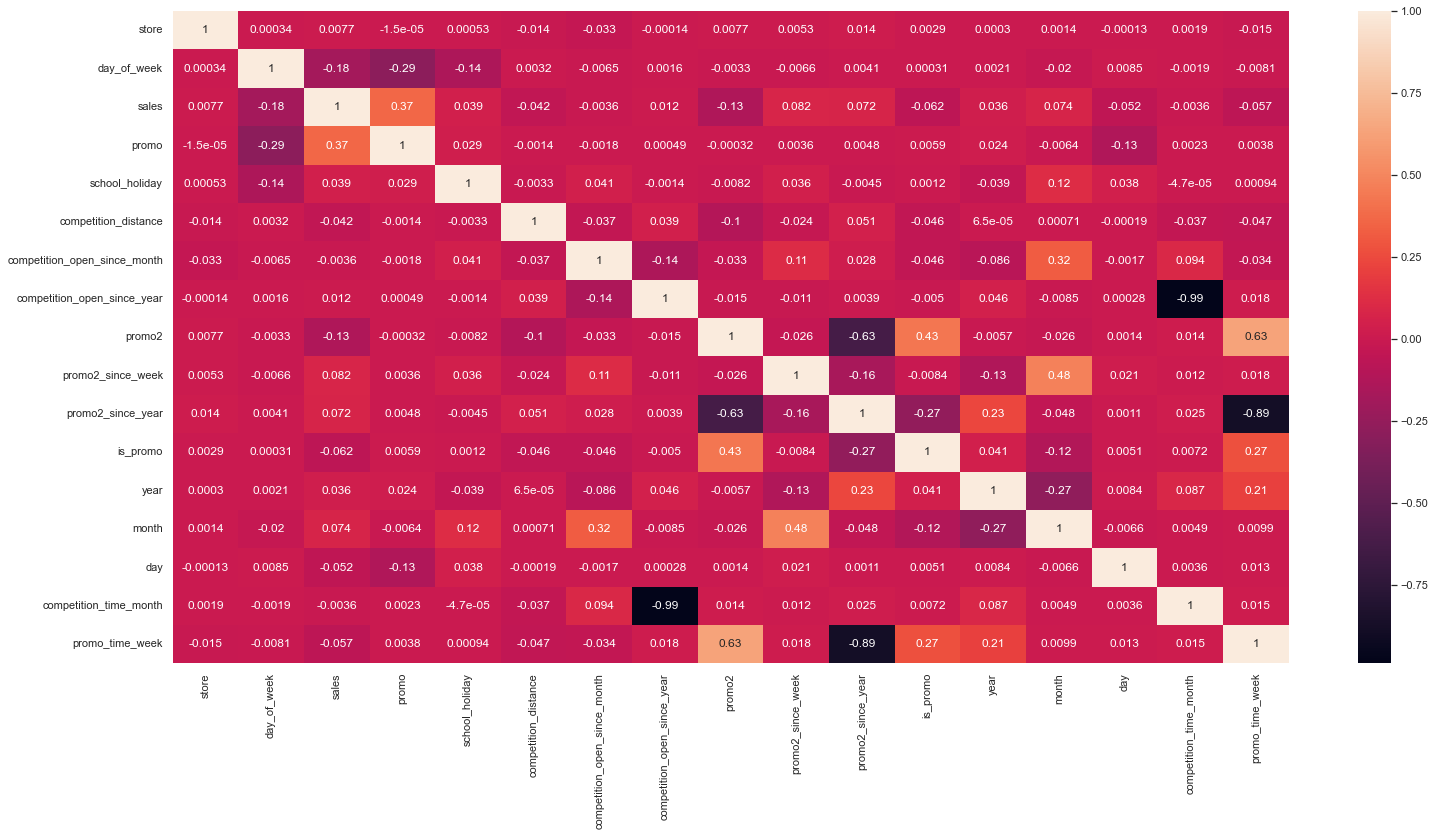

In [51]:
num_attributes = df4.select_dtypes(include=['int64','float64'])
correlations = num_attributes.corr(method='pearson')
sns.heatmap(correlations,annot=True)

### 4.3.2 Categorical Attributes

In [52]:
from scipy import stats  as ss

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [53]:
a = df4.select_dtypes(include='object')

In [54]:
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


<AxesSubplot:>

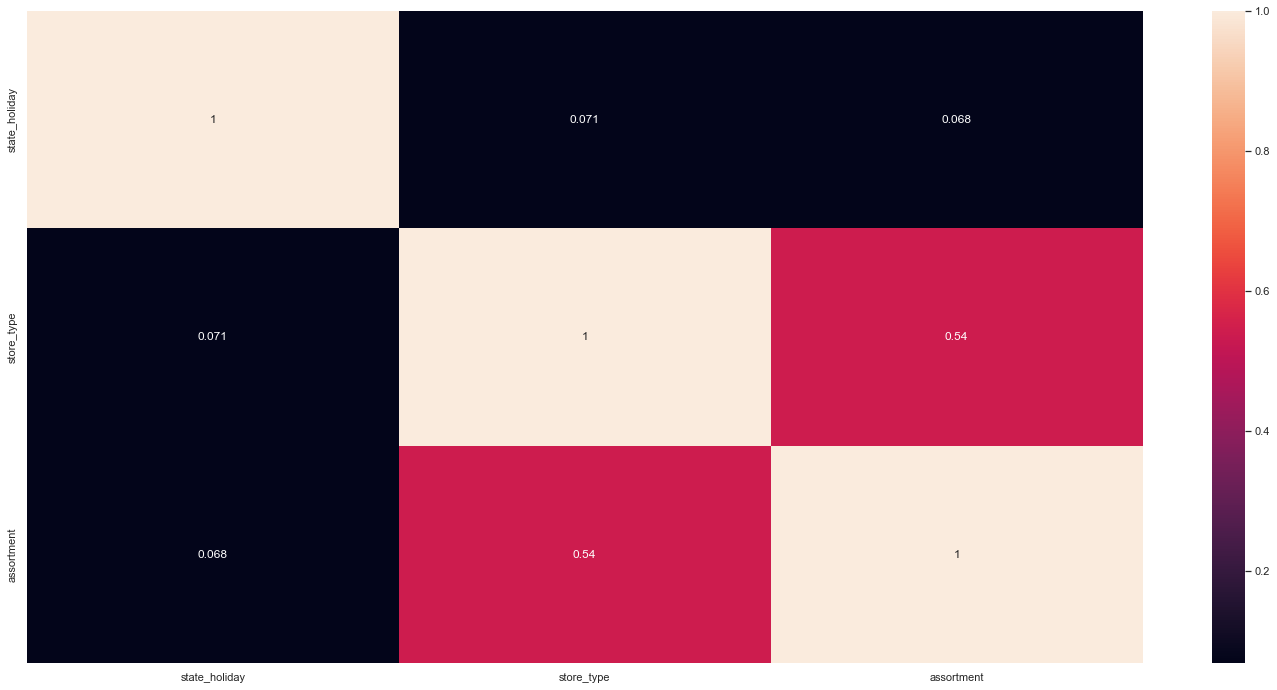

In [55]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 5.0. PASSO 5 - Data Preparation

In [56]:
df5 = df4.copy()

## 5.1. Normalização

In [57]:
# Como os dados não possuem uma distribuição normal, não faz sentido aplicarmos esse metodo

## 5.2. Rescaling

In [58]:
a = df5.select_dtypes(include=['int64','float64'])

C:\Users\Notebook\anaconda3\envs\ds-producao-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='promo_time_week'>

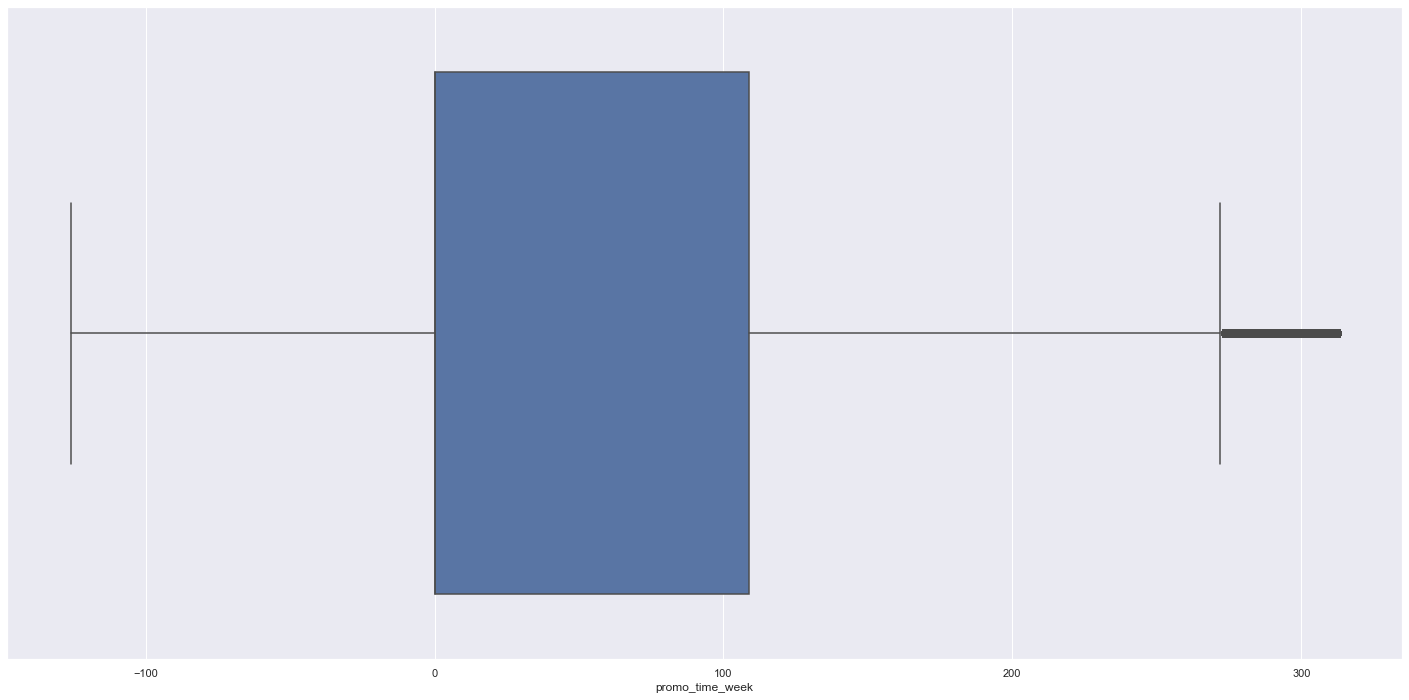

In [59]:
sns.boxplot(df5['promo_time_week'])

In [60]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )


C:\Users\Notebook\anaconda3\envs\ds-producao-env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

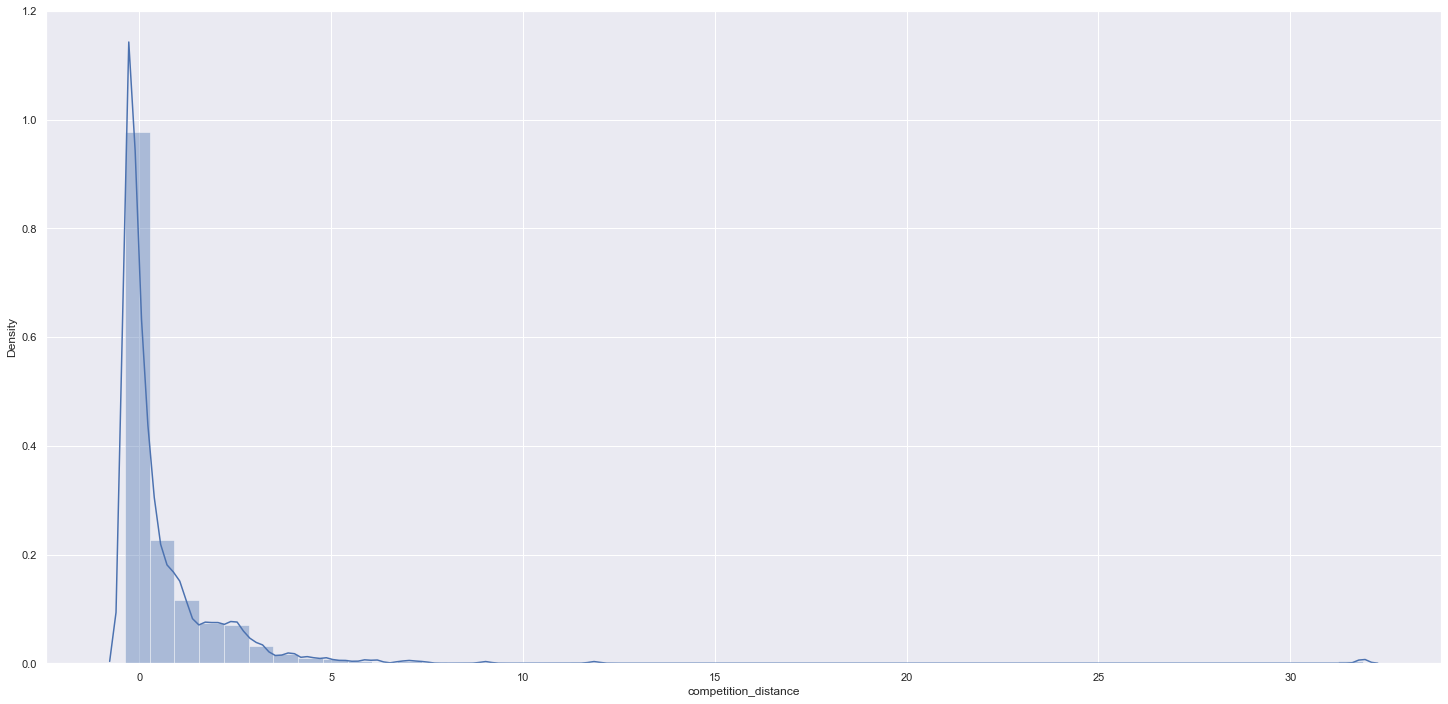

In [61]:
sns.distplot(df5['competition_distance'])

## 5.3. Transformação

### 5.3.1. Enconding

In [62]:
# month
# day
# week of year
# day of week

In [63]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [64]:
# state holiday
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store type
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment
assortment_dict = {'basic':1,'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)


### 5.3.2. Response variable transformation

In [65]:
df5['sales'] = np.log1p(df5['sales'])

In [66]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 5.3.3. Nature transformation

In [67]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

In [68]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


# 6.0 PASSO 6 - FEATURE SELECTION

In [69]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [70]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


In [71]:
cols_drop = ['day', 'month', 'day_of_week', "week_of_year", 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [72]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [73]:
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Teste Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Teste Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [74]:
# training and test dataset for boruta
X_train_n = X_train.drop(['date','sales'],axis=1).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs =-1)

# define boruta
# boruta = BorutaPy(rf, n_estimators = 'auto', verbose=2, random_state=42).fit(X_train_n,y_train_n)

### 6.2.1 Best features from boruta

In [75]:
# cols_select = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop(['date','sales'],axis=1)
# cols_select_boruta = X_train_fs.iloc[:, cols_select].columns.tolist()

# not select boruta
# cols_not_select_boruta = np.setdiff1d(X_train_fs.columns, cols_select_boruta)

NameError: name 'cols_select' is not defined

In [76]:
cols_select_boruta = ['store', 
                      'promo', 
                      'store_type', 
                      'assortment', 
                      'competition_distance', 
                      'competition_open_since_month',
                      'competition_open_since_year',
                      'promo2','promo2_since_week', 
                      'promo2_since_year',
                      'competition_time_month', 
                      'promo_time_week', 
                      'day_of_week_sin',
                      'day_of_week_cos',
                      'month_cos',
                      'month_sin',
                      'day_sin',
                      'day_cos',
                      'week_of_year_cos',
                      'week_of_year_sin']

In [77]:
cols_not_select_boruta = ['is_promo', 
                          'school_holiday',
                          'state_holiday_christmas', 
                          'state_holiday_easter_holiday',
                          'state_holiday_public_holiday', 
                          'state_holiday_regular_day',
                          'year']

In [78]:
# columns to add
feat_to_add = ['date','sales']

# final features
cols_select_boruta_full = cols_select_boruta.copy()
cols_select_boruta_full.extend(feat_to_add)

In [79]:
cols_select_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin']

# 7.0. PASSO 7 - MACHINE LEARNING MODELING

In [80]:
x_train = X_train[cols_select_boruta]
x_test = X_test[cols_select_boruta]

# Time Series Data Preparation
x_training = X_train[cols_select_boruta_full]

In [81]:
x_train.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,month_cos,month_sin,day_sin,day_cos,week_of_year_cos,week_of_year_sin
47945,1,1,2,1,-0.170968,9,2008,0,25,2015,0.891892,0.287016,-0.433884,-0.900969,-1.0,1.224647e-16,-0.587785,-0.809017,-0.992709,0.120537
47946,2,1,0,1,-0.283871,11,2007,1,13,2010,1.027027,0.908884,-0.433884,-0.900969,-1.0,1.224647e-16,-0.587785,-0.809017,-0.992709,0.120537
47947,3,1,0,1,1.903226,12,2006,1,14,2011,1.189189,0.788155,-0.433884,-0.900969,-1.0,1.224647e-16,-0.587785,-0.809017,-0.992709,0.120537
47948,4,1,2,3,-0.275806,9,2009,0,25,2015,0.729730,0.287016,-0.433884,-0.900969,-1.0,1.224647e-16,-0.587785,-0.809017,-0.992709,0.120537
47949,5,1,0,1,4.448387,4,2015,0,25,2015,-0.189189,0.287016,-0.433884,-0.900969,-1.0,1.224647e-16,-0.587785,-0.809017,-0.992709,0.120537


## 7.1. Average Model

In [82]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1,aux2,how='left',on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model',np.expm1(y_test),np.expm1(yhat_baseline))

## 7.2. Linear Regression Model

In [83]:
## 7.2. Linear Regression Model# model
lr = LinearRegression().fit(x_train,y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test),np.expm1(yhat_lr))

lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [84]:
lr_result_cv = cross_validation(x_training,5,'Linear Regression', lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1940.46 +/- 97.24,0.3 +/- 0.02,2735.18 +/- 194.98


## 7.3. Lasso Model

In [85]:
# model
lrr = Lasso(alpha=0.01).fit(x_train,y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test),np.expm1(yhat_lrr))

lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Lasso - Cross Validation

In [86]:
lrr_result_cv = cross_validation(x_training,5,'Lasso', lrr)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,1957.62 +/- 140.52,0.29 +/- 0.0,2828.15 +/- 232.95


## 7.4. Random Forest Regressor

In [87]:
# model
rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=42).fit(x_train,y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test),np.expm1(yhat_rf))

rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,677.455795,0.099667,1007.9169


### 7.4.1 Random Forest Regressor - Cross Validation

In [88]:
rf_result_cv = cross_validation(x_training,5,'Random Forest', rf, verbose=True)
rf_result_cv


KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


KeyboardInterrupt: 

## 7.5. XGBoost Regressor

In [ ]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

### 7.5.1 XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation(x_training,5,'XGBooster', model_xgb, verbose=True)
xgb_result_cv

## 7.6. Compare Model's Performance

### 7.6.1 Single Performance

In [ ]:
pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result])

### 7.6.2 Real Performance - Cross Validation

In [ ]:
pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgb_result_cv]) 

## 7.6. Compare Model's Performance

In [ ]:
x_training = X_train[cols_select_boruta_full]

In [ ]:
for k in reversed(range(1,6)):
    print(k)

In [ ]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        xtraining = training.drop(['date','sales'],axis=1)
        ytraining = training['sales']
        xvalidation = validation.drop(['date','sales'],axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining,ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error('Linear Regression', np.expm1(yvalidation),np.expm1(yhat))

        # store performance of each iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame(
        {'Model Name': model_name,
         'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
         'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)},index=[0])

In [ ]:
cross_validation(x_training,6, 'Lasso', Lasso())

In [ ]:
a

# 8.0. PASSO 8 - HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [104]:
import random
import warnings
warnings.filterwarnings('ignore')

In [105]:
param = {
          'n_estimators':[1500, 1700, 2500, 3000, 3500],
          'eta':[0.01, 0.03],
          'max_depth':[3,5,9],
          'subsample':[0.1, 0.5, 0.7],
          'colsample_bytree': [0.3, 0.7, 0.9],
          'min_child_weigth': [3,8,15]
}

MAX_EVAL = 10

In [106]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    
    # choose values for parameters randomly
    hp = {k: random.sample(v,1)[0] for k, v in param.items()}
    print(hp)

    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'], 
                                  eta=hp['eta'], 
                                  max_depth=hp['max_depth'], 
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weigth = hp['min_child_weigth'])

    # performance
    result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False )
    
    final_result = pd.concat([final_result, result])
    
final_result

{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weigth': 8}
[07:58:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_child_weigth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weigth': 15}
[08:16:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_child_weigth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1172.38 +/- 0.0,0.16 +/- 0.0,1687.03 +/- 0.0
0,XGBoost Regressor,1608.94 +/- 0.0,0.22 +/- 0.0,2319.42 +/- 0.0
0,XGBoost Regressor,1250.66 +/- 0.0,0.17 +/- 0.0,1798.66 +/- 0.0
0,XGBoost Regressor,1761.14 +/- 0.0,0.24 +/- 0.0,2531.56 +/- 0.0
0,XGBoost Regressor,788.25 +/- 0.0,0.11 +/- 0.0,1093.22 +/- 0.0
0,XGBoost Regressor,1745.05 +/- 0.0,0.24 +/- 0.0,2510.34 +/- 0.0
0,XGBoost Regressor,1105.4 +/- 0.0,0.15 +/- 0.0,1578.81 +/- 0.0
0,XGBoost Regressor,851.05 +/- 0.0,0.12 +/- 0.0,1199.39 +/- 0.0
0,XGBoost Regressor,753.63 +/- 0.0,0.11 +/- 0.0,1067.93 +/- 0.0
0,XGBoost Regressor,883.33 +/- 0.0,0.12 +/- 0.0,1251.34 +/- 0.0


In [107]:
final_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1172.38 +/- 0.0,0.16 +/- 0.0,1687.03 +/- 0.0
0,XGBoost Regressor,1608.94 +/- 0.0,0.22 +/- 0.0,2319.42 +/- 0.0
0,XGBoost Regressor,1250.66 +/- 0.0,0.17 +/- 0.0,1798.66 +/- 0.0
0,XGBoost Regressor,1761.14 +/- 0.0,0.24 +/- 0.0,2531.56 +/- 0.0
0,XGBoost Regressor,788.25 +/- 0.0,0.11 +/- 0.0,1093.22 +/- 0.0
0,XGBoost Regressor,1745.05 +/- 0.0,0.24 +/- 0.0,2510.34 +/- 0.0
0,XGBoost Regressor,1105.4 +/- 0.0,0.15 +/- 0.0,1578.81 +/- 0.0
0,XGBoost Regressor,851.05 +/- 0.0,0.12 +/- 0.0,1199.39 +/- 0.0
0,XGBoost Regressor,753.63 +/- 0.0,0.11 +/- 0.0,1067.93 +/- 0.0
0,XGBoost Regressor,883.33 +/- 0.0,0.12 +/- 0.0,1251.34 +/- 0.0


In [108]:
param_tuned = {'n_estimators': 3000, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weigth': 8}

In [109]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=param_tuned['n_estimators'], 
                              eta=param_tuned['eta'], 
                              max_depth=param_tuned['max_depth'], 
                              subsample=param_tuned['subsample'],
                              colsample_bytree=param_tuned['colsample_bytree'],
                              min_child_weigth = param_tuned['min_child_weigth']).fit(x_train,y_train)

yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

xgb_result_tuned = ml_error('XGBooster', np.expm1(y_test),np.expm1(yhat_xgb_tuned))

xgb_result_tuned

[12:14:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_child_weigth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE,MAPE,RMSE
0,XGBooster,621.568914,0.089866,911.263083


In [114]:
import pickle

In [116]:
pickle.dump(xgb_result_tuned,open('C:\\Users\\Notebook\\repos\\DS-Producao\\model_rossmann.pkl','wb'))